# Test the Hypothesis: Summary of Context Word Vectors Can Identify Different Frames

Our hypothesis is that we can identify different conceptual frames (so to speak) based upon some summary of the context words that surround a given term.

## Set-up
GloVe download can take 20-30 minutes in a Colab notebook. Feel free to try other embeddings as well [as listed here](https://torchtext.readthedocs.io/en/latest/vocab.html#torchtext.vocab.Vocab.load_vectors).

In [ ]:

import re

import nltk
import matplotlib.pyplot as plt
import torch
from sklearn.cluster import KMeans
from torchtext.vocab import GloVe

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
glove = GloVe()  # defaults to model built on 840 billion words

## Compile test sentences for a given term
**Not ideal, but for now, let's try it with CQPweb search results for "infect" or "viral" (smaller). Clean up, sentence-tokenize, and the make list of sentence strings that include the search term. Download the files here:  https://drive.google.com/file/d/1gNAtiPtEK1LKIn3i_zrEej_UYcqAcv17/view?usp=sharing ("viral") and https://drive.google.com/file/d/1EIdvMzI0aa8okmATxIMyMWltO5OeIwha/view?usp=sharing ("infect")



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving infect50.txt to infect50.txt


In [ ]:
def get_sentences(word, filepath):
    with open(filepath, encoding='utf-8', errors='ignore') as f:
        text = f.read()
        # to get rid of entry identifiers (e.g., "7	t__54e1311e_cf8b_11e6_8c57_2c600c9500f4"):
        text = re.sub('\n[0-9]+\t', '\n ', text)
        text = re.sub('t__\S{36}\s', '', text)
    
    entries = re.findall('\n', text)
    print("Total entries: ", len(entries))
    
    all_sentences = nltk.tokenize.sent_tokenize(text)
    
    sentences = list()
    
    for sentence in all_sentences:
        if re.search(r'(\s|^)' + word + r'(\s|[.,?!])', sentence):
            sentences.append(sentence)
    
    print("Total sentences: ", len(sentences))
    return sentences

sentences = get_sentences('infect', 'infect50.txt')

Total entries:  50986
Total sentences:  230


## Test for Optimal K Clusters Using the Elbow Method
The best number of clusters for the chosen word and the above sentences should be at the "elbow" of the line plot below. Consider trying `torch.mean` as well (and other aggregations).

In [ ]:
def summarize_word_context(word, sentence, window_size=5, method=torch.sum):
    tokens = re.findall(r'\w+', sentence.lower())
    word = word.lower()
    context_vectors = []
    word_index = tokens.index(word)
    for token in tokens[max(0, word_index - window_size):word_index + window_size]:
        if token != word and glove.stoi.get(token):
            token_vector = glove.vectors[glove.stoi[token]]
            context_vectors.append(token_vector)
    context_tensor = torch.stack(context_vectors)
    # returns summary of shape of single context vector
    return method(context_tensor, dim=0)

In [ ]:
def find_best_k(word, sentences, method=torch.sum, window_size=5):
    # sum of squared distances of samples to their closest cluster center
    context_summary_vectors = [summarize_word_context(
        word, sentence, window_size=window_size, method=method
        ) for sentence in sentences if word in sentence.lower()]
    if method in (torch.max, torch.min):
        context_summary_vectors = [v.values for v in context_summary_vectors]
    context_summary_tensor = torch.stack(context_summary_vectors)
    sum_squared_distances = []
    possibilities = list(range(1, min(len(sentences) + 1, 20)))
    for k in possibilities:
        km = KMeans(n_clusters=k)
        km = km.fit(context_summary_tensor.numpy())
        sum_squared_distances.append(km.inertia_)
    
    # plot
    plt.plot(possibilities, sum_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Plot for Optimal k')
    plt.show()

The following plot should have a distinct elbow at the ideal number of clusters (corresponding to different contexts) for the term used above.

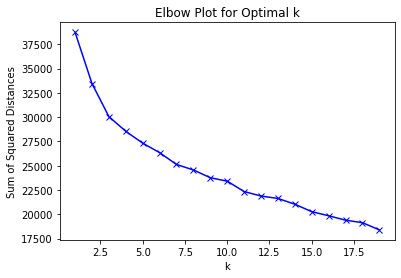

In [ ]:
find_best_k('infect', sentences, method=torch.sum, window_size=4)

## Find different contexts of word using k from elbow above

In [ ]:
def label_samples(word, sentences, method=torch.sum, k=2, topn=10, window_size=5):
    context_summary_vectors = [summarize_word_context(
        word, sentence, method=method, window_size=window_size
        ) for sentence in sentences if word in sentence.lower()]
    if method in (torch.max, torch.min):
        context_summary_vectors = [v.values for v in context_summary_vectors]
    context_summary_tensor = torch.stack(context_summary_vectors)
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(context_summary_tensor.numpy())
    labels_for_display = []
    for i, label in enumerate(kmeans.labels_[:topn]):
        labels_for_display.append((f'Label: {label} Sentence: {sentences[i]}', label))
    labels_for_display.sort(key=lambda x: x[1])
    for labeled_sent in labels_for_display:
        print(labeled_sent[0])

In [ ]:
label_samples('infect', sentences, method=torch.sum, window_size=4, k=4, topn=40)

Label: 0 Sentence: Tell us about how the malware did not infect the devices systems of your utility here .
Label: 0 Sentence: But the core summed up pretty I think concisely which is , when he said that while Prime Minister Netanyahu publicly supports a two-state solution , that word '' publicly'' underlined , his government is pursuing settlement policy that infect render it impractical and effectively extinguishing it .
Label: 0 Sentence: We have pointed out for years voting machines are computers and they have reprogrammable software and if they infect machines with malware they can give any answer .
Label: 0 Sentence: That is the total failure of all modes , methods of prediction , the total failure of infect participant measurement politically in this country .
Label: 0 Sentence: I can not sit idly by and watch as this abhorrent disease continues to infect what was once an honorable and respectable political party of the past .
Label: 0 Sentence: The lenses are sold over the count